In [1]:
# Run convertQuarterDataToLinear for your ordering (Passenger or Flights Flown)

fullDataSetFile="new_full_quarterData.csv"
topXSegmentsFile="new_topsegments_quarterData.csv"

filetoUse=topXSegmentsFile

In [2]:

import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LassoLars,ElasticNet, ElasticNetCV, BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# from tabulate import tabulate
import seaborn as sns
# import xgboost as xgb


warnings.filterwarnings("ignore") 

%matplotlib inline

df_toUse=pd.read_csv(topXSegmentsFile)

train = df_toUse.head(20)
test =  df_toUse[20:37]

pd.options.display.max_columns = 200  # None -> No Restrictions
pd.options.display.max_rows = 100    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [3]:
#Data cleansing
all_data = pd.concat((train,
                       test))

#log transform the target:
train['revenue'] = np.log1p(train['revenue'])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.concat([all_data,pd.get_dummies(all_data['citypair'], prefix='segment')],axis=1)
# all_data = pd.concat([all_data,pd.get_dummies(all_data['aircraft'], prefix='plane')],axis=1)

# all_data.drop(['citypair'],axis=1, inplace=True)
# all_data.drop(['aircraft'],axis=1, inplace=True)
      
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(0)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

X_train.drop(['revenue'],axis=1, inplace=True)
X_test.drop(['revenue'],axis=1, inplace=True)

y = train['revenue']
X_train

,year,quarter,fuel_price,stock_price,operational_expense,HOU-DAL-Boeing 737-300_flights_flown,HOU-DAL-Boeing 737-300_passengers_carried,DAL-HOU-Boeing 737-300_flights_flown,DAL-HOU-Boeing 737-300_passengers_carried,BUR-OAK-Boeing 737-700/700LR/Max 7_flights_flown,BUR-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-BUR-Boeing 737-700/700LR/Max 7_flights_flown,OAK-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,BUR-LAS-Boeing 737-700/700LR/Max 7_flights_flown,BUR-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-LAS-Boeing 737-700/700LR/Max 7_flights_flown,MDW-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-MDW-Boeing 737-700/700LR/Max 7_flights_flown,LAS-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-DEN-Boeing 737-700/700LR/Max 7_flights_flown,MDW-DEN-Boeing 737-700/700LR/Max 7_passengers_carried,HOU-DAL-Boeing 737-700/700LR/Max 7_flights_flown,HOU-DAL-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-BUR-Boeing 737-700/700LR/Max 7_flights_flown,LAS-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-RNO-Boeing 737-700/700LR/Max 7_flights_flown,LAS-RNO-Boeing 737-700/700LR/Max 7_passengers_carried,RNO-LAS-Boeing 737-700/700LR/Max 7_flights_flown,RNO-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-HOU-Boeing 737-700/700LR/Max 7_flights_flown,DAL-HOU-Boeing 737-700/700LR/Max 7_passengers_carried,SJC-SNA-Boeing 737-700/700LR/Max 7_flights_flown,SJC-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,FLL-BWI-Boeing 737-700/700LR/Max 7_flights_flown,FLL-BWI-Boeing 737-700/700LR/Max 7_passengers_carried,LAX-LAS-Boeing 737-700/700LR/Max 7_flights_flown,LAX-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-LAX-Boeing 737-700/700LR/Max 7_flights_flown,OAK-LAX-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-LAS-Boeing 737-800_flights_flown,MDW-LAS-Boeing 737-800_passengers_carried,LAX-OAK-Boeing 737-700/700LR/Max 7_flights_flown,LAX-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-MDW-Boeing 737-800_flights_flown,LAS-MDW-Boeing 737-800_passengers_carried,SAN-LAS-Boeing 737-700/700LR/Max 7_flights_flown,SAN-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-LAX-Boeing 737-700/700LR/Max 7_flights_flown,LAS-LAX-Boeing 737-700/700LR/Max 7_passengers_carried,SJC-SAN-Boeing 737-700/700LR/Max 7_flights_flown,SJC-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-SAN-Boeing 737-700/700LR/Max 7_flights_flown,OAK-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-SJC-Boeing 737-700/700LR/Max 7_flights_flown,SNA-SJC-Boeing 737-700/700LR/Max 7_passengers_carried,SMF-SAN-Boeing 737-700/700LR/Max 7_flights_flown,SMF-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-SMF-Boeing 737-700/700LR/Max 7_flights_flown,SAN-SMF-Boeing 737-700/700LR/Max 7_passengers_carried
0,2010,1,78.81,2.591,-2575561,1149,107530,1077,97114,1075,94881,1082,91959,6.897,11.360,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,2,77.82,2.628,-2805548,1230,119403,1032,101422,1080,103360,1066,100614,0.000,0.000,809,96569,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010,3,76.06,2.555,-2836702,1310,126379,990,95550,1043,100944,1052,99969,0.000,0.000,815,99340,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010,4,85.16,2.668,-2898066,1144,118670,1004,101133,1026,106352,1042,107951,0.000,0.000,784,94335,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2011,1,94.07,2.607,-2988795,907,90669,903,89313,997,95667,996,94654,0.000,0.000,714,83643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2011,2,102.02,2.549,-3400693,0,0,1015,104610,1021,100763,1008,98717,0.000,0

In [4]:
print(X_train.shape)
print(X_test.shape)

(20, 59)
(17, 59)


In [5]:
def rmse_cv(model, dataset):
    rmse= np.sqrt(-cross_val_score(model, dataset, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def outputPredictionToCSV(predictionData, filename):
    arr = test['year']
    arr2 = test['quarter']
#     arr3 = np.expm1(predictionData)
    arr3=predictionData
    df = pd.DataFrame(data=arr, columns = ["Year"])
    df.applymap(int) 
    
    df1 = pd.DataFrame(data=arr2, columns = ["Quarter"])
    df1.applymap(int)
    
    df2 = pd.DataFrame(data=arr3, columns = ['predict.revenue'])
        
    df4 = pd.concat([df,df1,df2], axis=1)
    dff = pd.DataFrame(data=df4) 
#     dff.to_csv(filename+".csv", index=False)
    

def printRMSE_MSE(modelName,model,trainData):
    print(modelName +" has RMSE of "+ str(rmse_cv(model,trainData).mean()))
    yHat= model.predict(trainData) 
    print(modelName + " has MSE on train data is: "+ str(mean_squared_error(y,yHat)))
    
def printActuals(predictionData):
    act_data = test
    act_data=act_data.reset_index(drop=True)
#     print(act_data)
    arr3 = np.expm1(predictionData)
    percentErrors =[]
    for x in range(len(act_data.revenue)):
        percentError= (100*(abs(act_data.revenue[x]-arr3[x])/act_data.revenue[x]))
        print("Quarter : "+str(act_data.quarter[x])+" Year: "+str(act_data.year[x])+" : Actual: "+str(act_data.revenue[x])+" ,Prediction: "+str(arr3[x])+" ,Error: "+ str(percentError)+"%")
        percentErrors.append(percentError)
    print("Avg Percent Error is : "+str(sum(percentErrors) / len(percentErrors) ))
    
    
def printTopTenFeatures(model):
    import operator
    coeff_used = np.sum(model.coef_!=0)
    print("Number of Coeffients used: "+ str(coeff_used))
    coef_dict = {} 

    indexOfFeature =0

    for coef in model.coef_:
        if coef!=0: 
            coef_dict[X_train.columns[indexOfFeature]]=coef
        indexOfFeature+=1
    highestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=True)[:5]
    print("Highest Coef: ")
    print(highestCoef_dict_sorted)
    lowestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=False)[:5]
    print("Lowest Coef: ")
    print(lowestCoef_dict_sorted)
            
    

In [6]:
# Find the best Alpha for the models Ridge RidgeCV, Lasso, 
# LassoCV, LassoLars,ElasticNet, ElasticNetCV, BayesianRidge

alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100, 500, 1000]

cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("The best Ridge regression : "+str(cv_ridge.min()) +" with Alpha as " + str(cv_ridge.idxmin()))
print("The top five are:\n"+ str(cv_ridge.sort_values().head(5)))


cv_ridgeCV = rmse_cv(RidgeCV(),X_train).mean() 
cv_ridgeCV = pd.Series(cv_ridgeCV, index = alphas)
print("\n\nThe best RidgeCV regression : "+str(cv_ridgeCV.min()) +" with Alpha as " + str(cv_ridgeCV.idxmin()))
print("The top five are:\n"+ str(cv_ridgeCV.sort_values().head(5)))


cv_lasso = [rmse_cv(Lasso(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
print("\n\nThe best Lasso regression : " +str(cv_lasso.min()) +" with Alpha as " + str(cv_lasso.idxmin()))
print("The top five are:\n"+ str(cv_lasso.sort_values().head(5)))


cv_lassoCV = rmse_cv(LassoCV(),X_train).mean() 
cv_lassoCV = pd.Series(cv_lassoCV, index = alphas)
print("\n\nThe best LassoCV regression : " +str(cv_lassoCV.min()) +" with Alpha as " + str(cv_lassoCV.idxmin()))
print("The top five are:\n"+ str(cv_lassoCV.sort_values().head(5)))



cv_lassoLars = [rmse_cv(LassoLars(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lassoLars = pd.Series(cv_lassoLars, index = alphas)
print("\n\nThe best Lasso Lars regression : " +str(cv_lassoLars.min()) +" with Alpha as " + str(cv_lassoLars.idxmin()))
print("The top five are:\n"+ str(cv_lassoLars.sort_values().head(5)))


cv_elasticNet = [rmse_cv(ElasticNet(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)
print("\n\nThe best ElasticNet regression : " +str(cv_elasticNet.min()) +" with Alpha as " + str(cv_elasticNet.idxmin()))
print("The top five are:\n"+ str(cv_elasticNet.sort_values().head(5)))


cv_elasticNetCV = rmse_cv(ElasticNetCV(),X_train).mean() 
cv_elasticNetCV = pd.Series(cv_elasticNetCV, index = alphas)
print("\n\nThe best ElasticNetCV regression : " +str(cv_elasticNetCV.min()) +" with Alpha as " + str(cv_elasticNetCV.idxmin()))
print("The top five are:\n"+ str(cv_elasticNetCV.sort_values().head(5)))


cv_bayesianRidge = rmse_cv(BayesianRidge(),X_train).mean() 
            
cv_bayesianRidge = pd.Series(cv_bayesianRidge, index = alphas)
print("\n\nThe best BayesianRidge regression : " +str(cv_bayesianRidge.min()) +" with Alpha as " + str(cv_bayesianRidge.idxmin()))
print("The top five are:\n"+ str(cv_bayesianRidge.sort_values().head(5)))


The best Ridge regression : 0.1897165896723762 with Alpha as 1000.0
The top five are:
1000.0    0.190
500.0     0.192
100.0     0.206
75.0      0.210
50.0      0.214
dtype: float64


The best RidgeCV regression : 0.22717369711682506 with Alpha as 5e-06
The top five are:
5.000e-06    0.227
1.000e+02    0.227
7.500e+01    0.227
5.000e+01    0.227
3.000e+01    0.227
dtype: float64


The best Lasso regression : 0.08016874576459404 with Alpha as 500.0
The top five are:
500.0     0.080
1000.0    0.097
100.0     0.111
75.0      0.118
50.0      0.126
dtype: float64


The best LassoCV regression : 0.13173539673832318 with Alpha as 5e-06
The top five are:
5.000e-06    0.132
1.000e+02    0.132
7.500e+01    0.132
5.000e+01    0.132
3.000e+01    0.132
dtype: float64


The best Lasso Lars regression : 0.12679914525617972 with Alpha as 0.005
The top five are:
0.005      0.127
7.000      0.185
100.000    0.185
75.000     0.185
50.000     0.185
dtype: float64


The best ElasticNet regression : 0.080168

In [7]:
# ridge regression with best alpha
modelForRidge= Ridge(alpha = cv_ridge.idxmin()).fit(X_train, y)

printRMSE_MSE('ridge_regression_withBestAlpha',modelForRidge,X_train)

predictforRidge= modelForRidge.predict(X_test)
outputPredictionToCSV(predictforRidge,'ridge_regression_WithBestAlpha_output')
printActuals(predictforRidge)
printTopTenFeatures(modelForRidge)

ridge_regression_withBestAlpha has RMSE of 0.1897165896723762
ridge_regression_withBestAlpha has MSE on train data is: 0.0009257591332214748
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3876239.6843534904 ,Error: 12.18306107037856%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4545553.467921352 ,Error: 11.063324830339424%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4654921.985275387 ,Error: 12.46855988575805%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 2709485.6717051854 ,Error: 45.55986193077787%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4362971.28532741 ,Error: 9.594461555586193%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 2891905.189864816 ,Error: 46.28705070830579%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 3157320.0938595757 ,Error: 38.56158603114272%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 2901870.8953085104 ,Error: 41.25767418403825%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 2989295.1

In [8]:
# RidgeCV 
modelForRidgeCV= RidgeCV().fit(X_train, y)

printRMSE_MSE('ridge_regressionCV',modelForRidgeCV,X_train)

predictforRidgeCV= modelForRidgeCV.predict(X_test)
outputPredictionToCSV(predictforRidgeCV,'ridge_regressionCV_output')
printActuals(predictforRidgeCV)
printTopTenFeatures(modelForRidgeCV)

ridge_regressionCV has RMSE of 0.22717369711682506
ridge_regressionCV has MSE on train data is: 9.674569110557272e-05
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3609389.4982320108 ,Error: 18.22860221495218%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4564302.110700187 ,Error: 10.696495584030771%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4503591.95557475 ,Error: 15.314179097879844%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 1652096.6564197124 ,Error: 66.80537158087779%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 5171743.898700009 ,Error: 7.164191850393889%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 1704864.399411251 ,Error: 68.33461368106889%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 1742965.2034447344 ,Error: 66.08357261247842%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 1687201.8177847792 ,Error: 65.8461170488911%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 2018705.3613952475 ,Error: 58.41

In [9]:
# Lasso with best alpha
modelForLasso= Lasso(alpha = cv_lasso.idxmin()).fit(X_train, y)

printRMSE_MSE('lasso_regression_withBestAlpha',modelForLasso,X_train)

predictforLasso= modelForLasso.predict(X_test)
outputPredictionToCSV(predictforLasso,'lasso_regression_WithBestAlpha_output')
printActuals(predictforLasso)
printTopTenFeatures(modelForLasso)

lasso_regression_withBestAlpha has RMSE of 0.08016874576459404
lasso_regression_withBestAlpha has MSE on train data is: 0.0029287706887839394
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3830114.2661897345 ,Error: 13.228041092212631%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4381908.208947653 ,Error: 14.265149502100313%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4484658.566763395 ,Error: 15.670203708849279%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4271200.091931331 ,Error: 14.181231827781174%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4171675.660821771 ,Error: 13.558316186867575%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4508101.909315897 ,Error: 16.26853808848631%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5060645.491811918 ,Error: 1.5247034089916698%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4700460.310943224 ,Error: 4.848981559853774%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 46921

In [10]:
#LassoLars with best Alpha
modelForLassoLars= LassoLars(alpha = cv_lassoLars.idxmin()).fit(X_train, y)

printRMSE_MSE('lasso_lars_regression_withBestAlpha',modelForLassoLars,X_train)

predictforLassoLars= modelForLassoLars.predict(X_test)
outputPredictionToCSV(predictforLassoLars,'lasso_lars_regression_withBestAlpha_output')
printActuals(predictforLassoLars)
printTopTenFeatures(modelForLassoLars)

lasso_lars_regression_withBestAlpha has RMSE of 0.12679914525617972
lasso_lars_regression_withBestAlpha has MSE on train data is: 0.0050454484903402
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3882224.36869842 ,Error: 12.04747692119574%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4249637.643661515 ,Error: 16.853108126364415%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4283488.7027582945 ,Error: 19.453014239219733%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4143463.9792715213 ,Error: 16.747760111080545%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4055510.080085552 ,Error: 15.965394113436556%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4317789.905493929 ,Error: 19.803307847438166%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 4640854.9612179585 ,Error: 9.693423599572709%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4462094.678896493 ,Error: 9.674196783471796%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction

In [11]:
# model for ElasticNet with best alpha
modelForElasticNet= ElasticNet(alpha = cv_elasticNet.idxmin(), random_state=0).fit(X_train, y)

printRMSE_MSE('elasticNet_regression_withBestAlpha',modelForElasticNet,X_train)

predictforElasticNet= modelForElasticNet.predict(X_test)
outputPredictionToCSV(predictforElasticNet,'elasticNet_regression_withBestAlpha_output')
printActuals(predictforElasticNet)
printTopTenFeatures(modelForElasticNet)

elasticNet_regression_withBestAlpha has RMSE of 0.08016879548528663
elasticNet_regression_withBestAlpha has MSE on train data is: 0.002928771362151988
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3830114.3613030137 ,Error: 13.228038937403404%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4381908.247953319 ,Error: 14.265148738929387%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4484658.594379549 ,Error: 15.670203189553424%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4271200.142889181 ,Error: 14.181230803914383%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4171675.7222346887 ,Error: 13.558314914324725%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4508101.93429416 ,Error: 16.268537624551254%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5060645.450592812 ,Error: 1.5247042110758484%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4700460.31373866 ,Error: 4.848981503265993%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Predicti

In [12]:
# model for ElasticNetCV
modelForElasticNetCV= ElasticNetCV(random_state=0).fit(X_train, y)

printRMSE_MSE('elasticNetCV_regression',modelForElasticNetCV,X_train)

predictforElasticNetCV= modelForElasticNetCV.predict(X_test)
outputPredictionToCSV(predictforElasticNetCV,'elasticNetCV_regression_output')
printActuals(predictforElasticNetCV)
printTopTenFeatures(modelForElasticNetCV)

elasticNetCV_regression has RMSE of 0.13173536482315357
elasticNetCV_regression has MSE on train data is: 0.002542660241898928
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3800195.3446063693 ,Error: 13.905859886579764%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4376418.5409463085 ,Error: 14.37255838492842%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4484125.144989318 ,Error: 15.68023420478905%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4260508.711253705 ,Error: 14.396047593857636%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4156433.407555905 ,Error: 13.874152350685762%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4508716.327006871 ,Error: 16.257126170006114%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5090062.825251955 ,Error: 0.9522703784402684%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4710726.732611689 ,Error: 4.641159258872697%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 4702001.587981728 ,E

In [13]:
# model for BayesianRidge
modelForBayesianRidge= BayesianRidge().fit(X_train, y)

printRMSE_MSE('BayesianRidge_regression',modelForBayesianRidge,X_train)

predictforBayesianRidge= modelForBayesianRidge.predict(X_test)
outputPredictionToCSV(predictforElasticNet,'BayesianRidge_regression_output')
printActuals(predictforBayesianRidge)
printTopTenFeatures(modelForBayesianRidge)

BayesianRidge_regression has RMSE of 0.23089275568931997
BayesianRidge_regression has MSE on train data is: 2.0839683330373195e-08
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3560927.5822303314 ,Error: 19.32651603465493%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4762165.001800852 ,Error: 6.82518094696044%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4612312.899060763 ,Error: 13.269783770952174%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 1036614.3035294903 ,Error: 79.17190469098875%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 6236540.801369121 ,Error: 29.22794864005639%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 984858.001866212 ,Error: 81.7076894155607%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 922685.9710209564 ,Error: 82.04541796028495%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 940179.8338749192 ,Error: 80.96801955718786%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 1285462.213971665 ,Erro

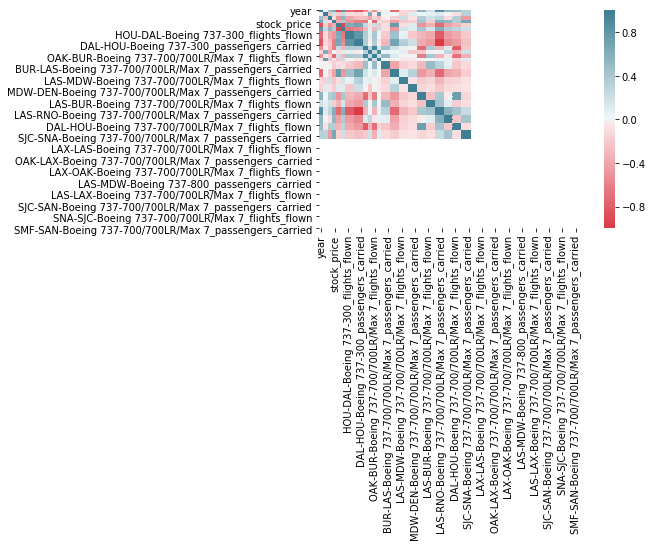

In [14]:
corr = train.corr()
# plt.subplots(figsize=(40,25))
ax = sns.heatmap(
    corr, 
#     vmin=-5, vmax=5, center=0,
    cmap=sns.diverging_palette(10, 220, sep=5, n=200)
#     square=True
)
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );